In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import sys
import subprocess
import datetime as dt
import itertools
from dask.distributed import Client, LocalCluster, wait
import dask.array as da
import cmocean
from MHW_daily_calcs import *

SEDI was higher, particularly for tropical Pacific, when no smoothing was applied. Try to identify cause. First, compare detrended anomaly time series.

In [2]:
lmax=50 # start by looking at 1st 50 days of each run

In [3]:
class mhwargs:
    def __init__(self,smooth=True):
        self.climyrs=[1993,2023]
        self.qtile=0.90
        self.detr=True
        self.qtvar='qt1'
        if smooth==True:
            self.smoothClim=True
            self.smoothTrend=True
            self.meth=method
            self.win=halfwin # = 10
            self.delt=15
        else:
            self.smoothClim=False
            self.smoothTrend=False
            self.meth=None
            self.win=0
            self.qtvar='qt1'
            self.delt=0
            
argsSm=mhwargs(True)
argsNS=mhwargs(False)
def loadfAnom(args,lmax,jj):
    flist=[fnameCanESMAnomDetrByLead(workdir, args.climyrs[0], args.climyrs[-1], ilead, jj, smoothClim=args.smoothClim,
                                smoothTrend=args.smoothTrend,meth=args.meth,win=args.win) \
                                for ilead in range(0,lmax)]
    fSEDI=xr.open_mfdataset(flist,combine='nested',concat_dim=['lead'],chunks={'lead':50,'reftime':1,'r':20,'lat':30,'lon':30},)
    return fSEDI
def loadfMHW(args,lmax,jj):
    flist=[fnameCanESMMHW(workdir, args.climyrs[0], args.climyrs[-1], ilead, jj, args.qtile,args.detr,smoothClim=args.smoothClim,
                                smoothTrend=args.smoothTrend,meth=args.meth,win=args.win,delt=args.delt,qtvar=args.qtvar) \
                               for ilead in range(0,lmax)]
    ff=xr.open_mfdataset(flist,combine='nested',concat_dim=['lead'],chunks={'lead':50,'reftime':1,'r':20,'lat':30,'lon':30},)
    return ff

In [4]:
argsNS.smoothClim

False

In [5]:
# load detended anomalies
fAnom={}
fAnom['S']=loadfAnom(argsSm,lmax,60)

In [6]:
fAnom['N']=loadfAnom(argsNS,lmax,60)

In [7]:
fMHW={}
fMHW['S']=loadfMHW(argsSm,lmax,60)

In [8]:
fMHW['N']=loadfMHW(argsNS,lmax,60)

In [9]:
jj=60

In [10]:
p1=[215,220,80-jj,85-jj]
#ax.plot([p1[0],p1[1],p1[1],p1[0],p1[0]],[p1[2],p1[2],p1[3],p1[3],p1[2]],'-',color='r')
#p2=[295,300,127,132]
#p3=[219,224,136,141]
p4=[145,146,90-jj,91-jj]

In [11]:
fMHW['S']

<xarray.Dataset> Size: 69GB
Dimensions:   (lead: 50, reftime: 378, r: 20, lat: 60, lon: 360)
Coordinates:
    leadtime  (lead) timedelta64[ns] 400B 0 days 15:00:00 ... 49 days 15:00:00
  * reftime   (reftime) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2024-06-01
  * r         (r) int64 160B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * lat       (lat) float64 480B -29.5 -28.5 -27.5 -26.5 ... 26.5 27.5 28.5 29.5
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: lead
Data variables:
    isMHW     (lead, reftime, r, lat, lon) float64 65GB dask.array<chunksize=(1, 1, 20, 30, 30), meta=np.ndarray>
    MHW_prob  (lead, reftime, lat, lon) float64 3GB dask.array<chunksize=(1, 1, 30, 30), meta=np.ndarray>

In [12]:
fAnom['N']

<xarray.Dataset> Size: 65GB
Dimensions:   (lead: 50, reftime: 378, r: 20, lat: 60, lon: 360)
Coordinates:
  * lat       (lat) float64 480B -29.5 -28.5 -27.5 -26.5 ... 26.5 27.5 28.5 29.5
    leadtime  (lead) timedelta64[ns] 400B 0 days 15:00:00 ... 49 days 15:00:00
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * reftime   (reftime) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2024-06-01
  * r         (r) int64 160B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Dimensions without coordinates: lead
Data variables:
    sst_an    (lead, reftime, r, lat, lon) float64 65GB dask.array<chunksize=(1, 1, 20, 30, 30), meta=np.ndarray>

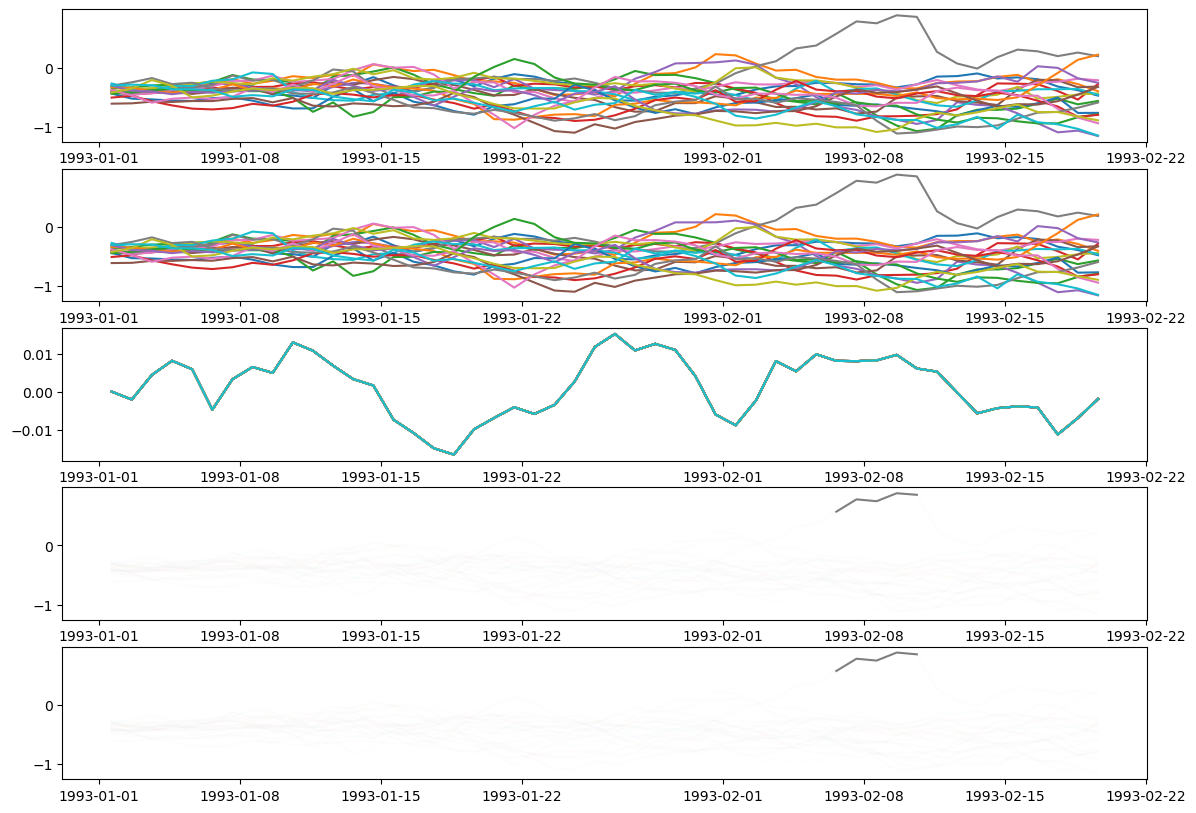

In [13]:
fig,ax=plt.subplots(5,1,figsize=(14,10))
p=p4
for ilat in range(p[2],p[3]):
    for ilon in range(p[0],p[1]):
        for irt in (0,):#range(0,378):
            tt=fAnom['S']['reftime'][irt].values+fAnom['S']['leadtime'].values
            SS=fAnom['S']['sst_an'][:,irt,:,ilat,ilon].values
            NN=fAnom['N']['sst_an'][:,irt,:,ilat,ilon].values
            MS=fMHW['S']['isMHW'][:,irt,:,ilat,ilon].values
            MN=fMHW['N']['isMHW'][:,irt,:,ilat,ilon].values
            ax[0].plot(tt,SS)
            ax[1].plot(tt,NN)
            ax[2].plot(tt,NN-SS)
            ax[3].plot(tt,SS,alpha=.01)
            ax[4].plot(tt,NN,alpha=.01)
            ax[3].plot(tt,np.where(MS==1,SS,np.nan))
            ax[4].plot(tt,np.where(MN==1,NN,np.nan))

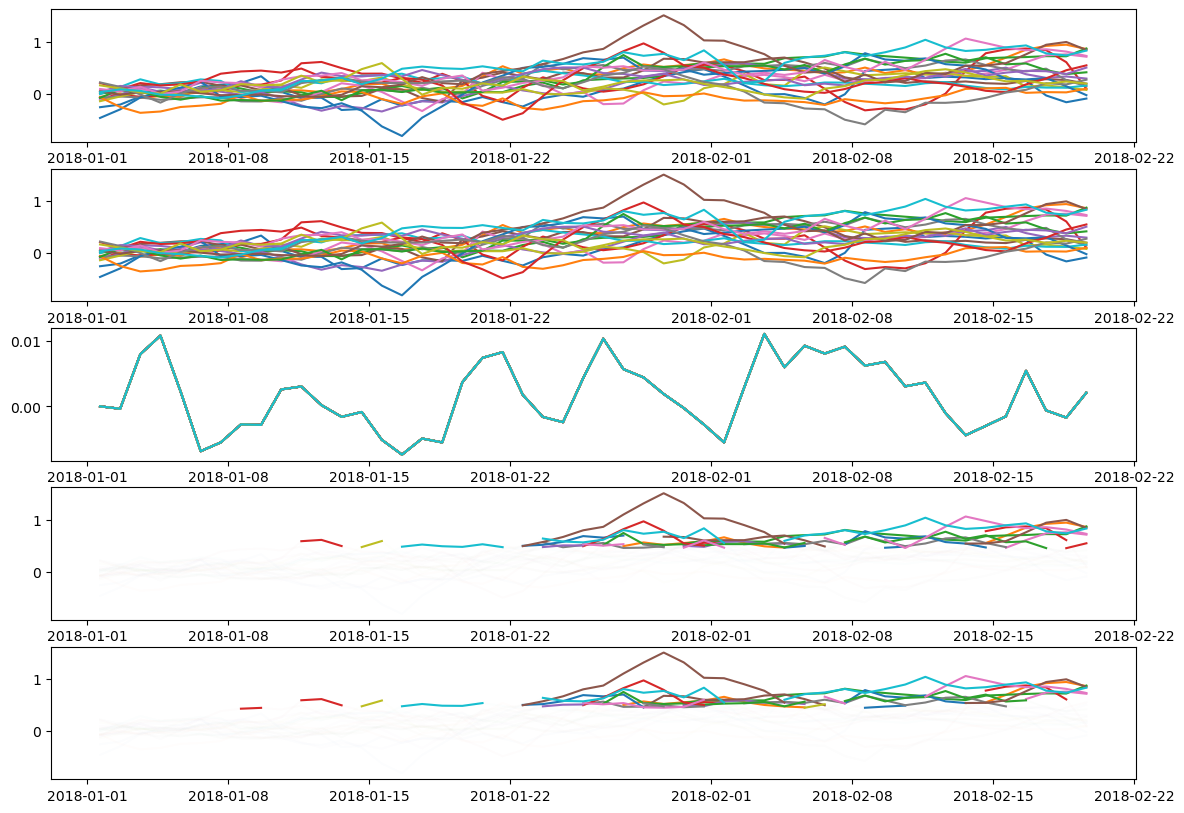

In [14]:
fig,ax=plt.subplots(5,1,figsize=(14,10))
p=p4
for ilat in range(p[2],p[3]):
    for ilon in range(p[0],p[1]):
        for irt in (300,):#range(0,378):
            tt=fAnom['S']['reftime'][irt].values+fAnom['S']['leadtime'].values
            SS=fAnom['S']['sst_an'][:,irt,:,ilat,ilon].values
            NN=fAnom['N']['sst_an'][:,irt,:,ilat,ilon].values
            MS=fMHW['S']['isMHW'][:,irt,:,ilat,ilon].values
            MN=fMHW['N']['isMHW'][:,irt,:,ilat,ilon].values
            ax[0].plot(tt,SS)
            ax[1].plot(tt,NN)
            ax[2].plot(tt,NN-SS)
            ax[3].plot(tt,SS,alpha=.01)
            ax[4].plot(tt,NN,alpha=.01)
            ax[3].plot(tt,np.where(MS==1,SS,np.nan))
            ax[4].plot(tt,np.where(MN==1,NN,np.nan))

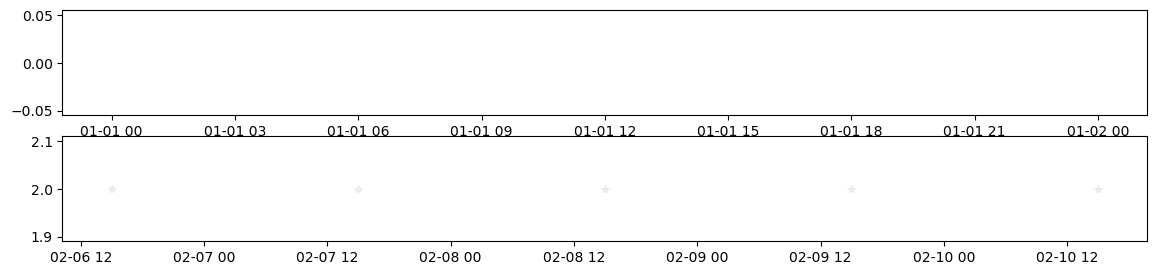

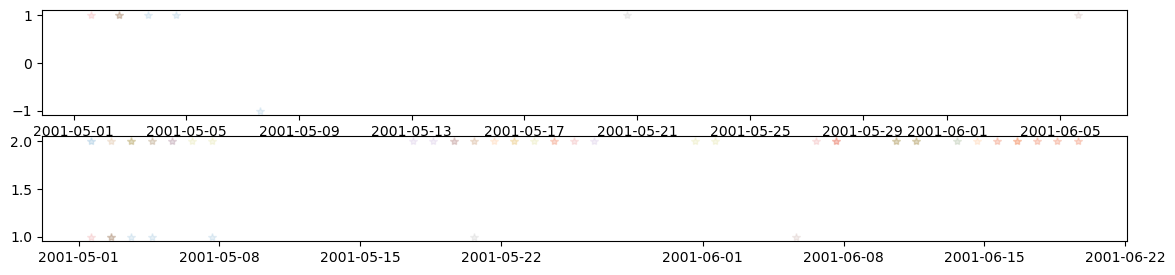

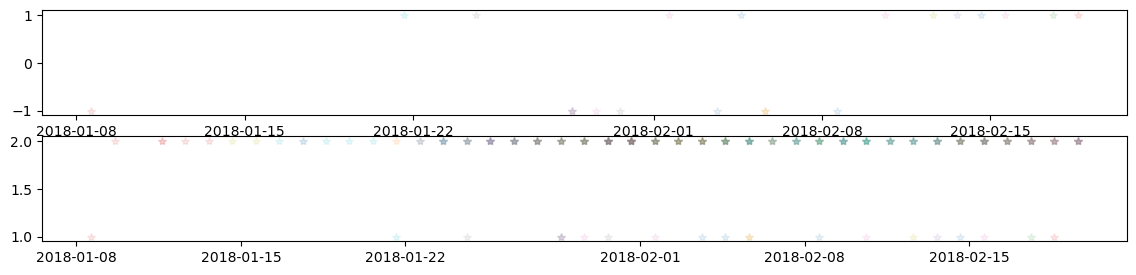

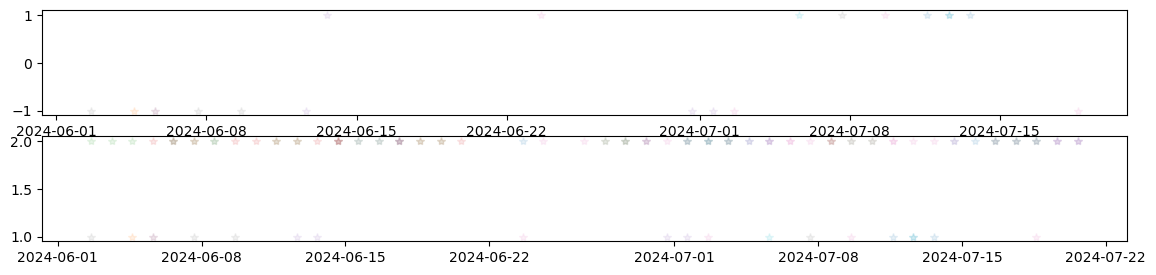

In [15]:
p=p4
for irt in (0,100,300,377):#range(0,378,20):
    fig,ax=plt.subplots(2,1,figsize=(14,3))
    for ilat in range(p[2],p[3]):
        for ilon in range(p[0],p[1]):
            tt=fAnom['S']['reftime'][irt].values+fAnom['S']['leadtime'].values
            MS=fMHW['S']['isMHW'][:,irt,:,ilat,ilon].values
            MN=fMHW['N']['isMHW'][:,irt,:,ilat,ilon].values
            ax[0].plot(tt,np.where(MS-MN!=0,MS-MN,np.nan),'*',alpha=.1)
            ax[1].plot(tt,np.where(MS+MN!=0,MS+MN,np.nan),'*',alpha=.1)

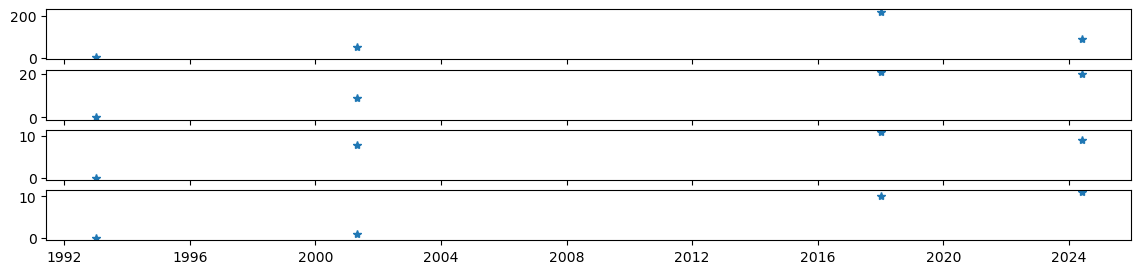

In [16]:
p=p4
countboth=[]
countdiff=[]
countSmore=[]
countSless=[]
ts=[]
for irt in (0,100,300,377):#range(0,378,20):
    for ilat in range(p[2],p[3]):
        for ilon in range(p[0],p[1]):
            tt=fAnom['S']['reftime'][irt].values+fAnom['S']['leadtime'].values
            MS=fMHW['S']['isMHW'][:,irt,:,ilat,ilon].values
            MN=fMHW['N']['isMHW'][:,irt,:,ilat,ilon].values
            countboth.append(np.nansum(MS+MN==2))
            countdiff.append(np.nansum(MS-MN!=0))
            countSmore.append(np.nansum(MS-MN==1))
            countSless.append(np.nansum(MS-MN==-1))
            ts.append(tt[0])

fig,ax=plt.subplots(4,1,figsize=(14,3))
ax[0].plot(ts,countboth,'*')
ax[1].plot(ts,countdiff,'*')
ax[2].plot(ts,countSmore,'*')
ax[3].plot(ts,countSless,'*')